# EX07 난 스케치를 할 테니 너는 채색을 하거라~

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


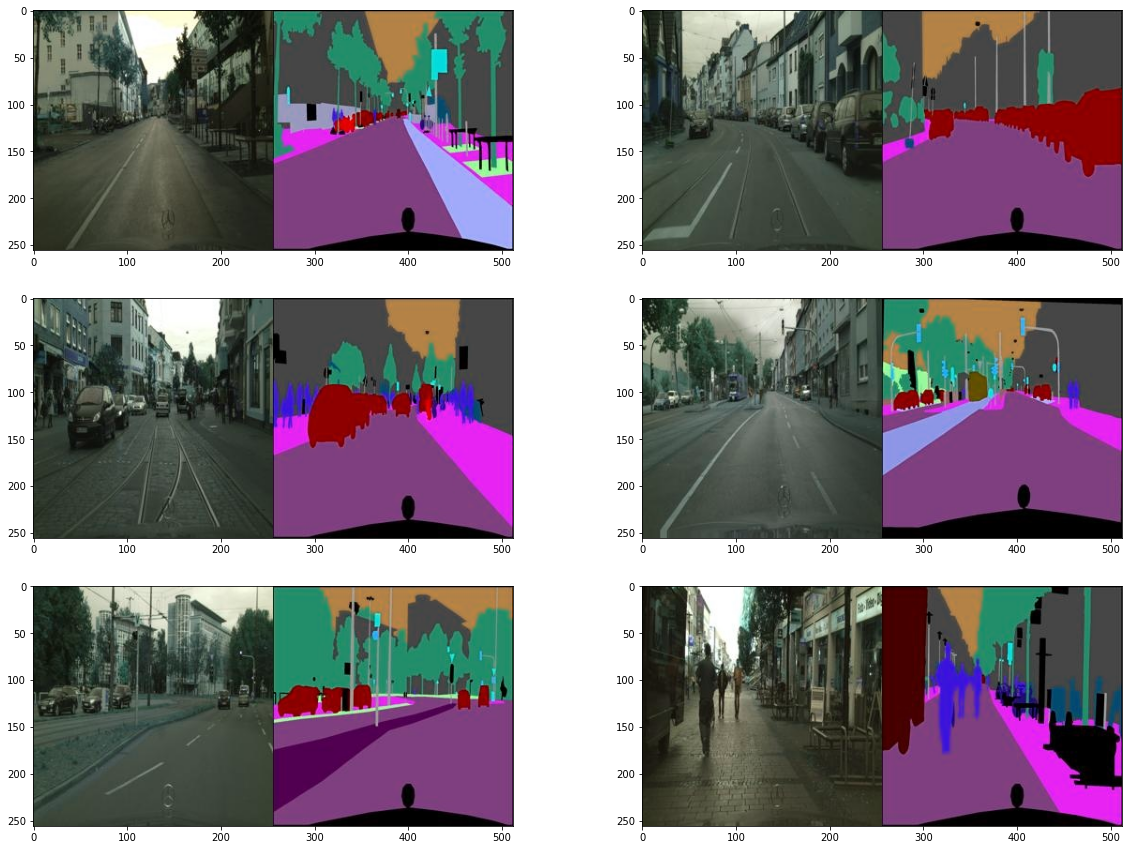

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [27]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


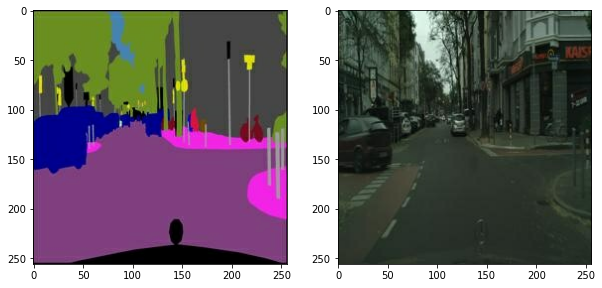

In [28]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

# 01 Data augmentation

In [29]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() 
def apply_augmentation(sketch, colored):
    #같이 연산작업 처리하기위해 6채널로 합침
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:#50퍼 확률로 가장자리 혹은 흰색으로 패딩주기
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    #패딩된 이미지 크기를 다시 알맞게 조정
    out = image.random_crop(padded, size=[256, 256, 6])
    
    #이미지 50%확률로 가로세로축으로 뒤집기
    if tf.random.uniform(()) < .5:
        out = image.random_flip_left_right(out)
    if tf.random.uniform(()) < .5:
        out = image.random_flip_up_down(out)
    
    # 50프로 확률로 90도 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    #이미지 다시 3채널씩 분리
    return out[...,:3], out[...,3:]   

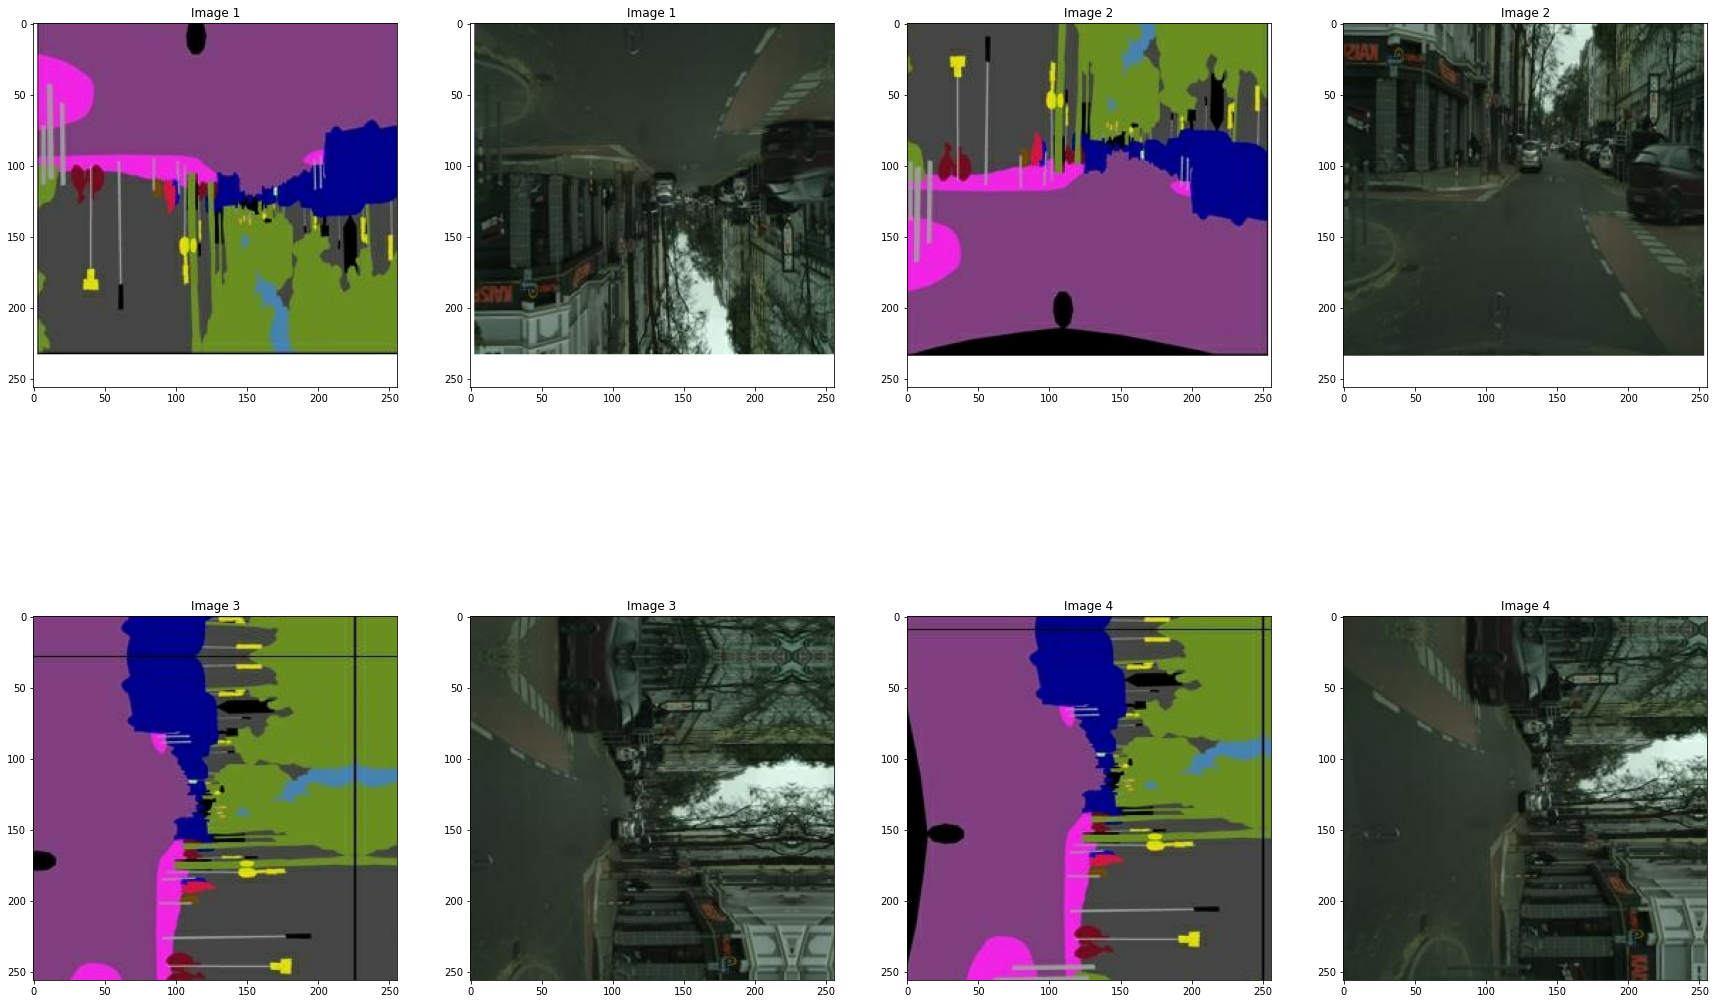

In [30]:
#적용확인
plt.figure(figsize=(30,20))
img_n = 1
for i in range(1, 9, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(2,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(2,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

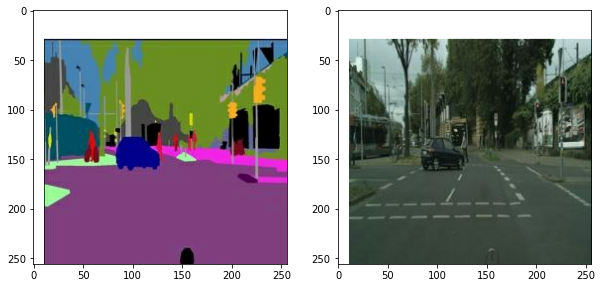

In [31]:
#데이터셋 생성
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 02 모델 생성

In [32]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


In [33]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        # for문과 리스트 filter를 활용해서 EncoderBlock을 쌓아주세요.
        # 조건 1. 첫번째 EncoderBlock의 경우 Batch Normalization을 생략해주세요.
        self.blocks = [] 
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
                
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [34]:
Encoder().get_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_32 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_33 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_34 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_35 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_36 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_37 (EncodeBlock (None, 4, 4, 512)         4196

In [35]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        # for문을 이용해서 모델을 쌓아주세요.
        # 조건 1. 3번째 block까지는 Dropout을 사용하되 그 이후에는 Dropout을 사용하지 마세요.
        # for문이 끝난 다음 Conv2DTranspose를 쌓아주되 output 차원수는 3, filter 사이즈는 4, stride는 2로 구성해주시고 자동 패딩 적용해주시되 bias는 사용하지 않습니다.
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

In [36]:
Decoder().get_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block_28 (DecodeBlock (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_29 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_30 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_31 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_32 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_33 (DecodeBlock (None, 64, 64, 128)       5248

In [37]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [39]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])#skip connection
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [40]:
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

In [41]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [42]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_115 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [43]:
#판별자 모델
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    

In [44]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_17[0][0]      

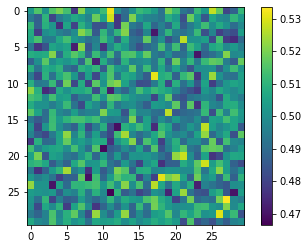

In [45]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [57]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [58]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [48]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


# 03모델 학습

In [49]:
EPOCHS = 30

generator = UNetGenerator()
discriminator = Discriminator()
L1loss,G_loss,D_loss=[],[],[]
for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            L1loss.append(l1_loss)
            G_loss.append(g_loss)
            D_loss.append(d_loss)
        if (i+1) % 125 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                        \nGenerator_loss:{g_loss.numpy():.4f} \
                        \nL1_loss:{l1_loss.numpy():.4f} \
                        \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n") 

EPOCH[1] - STEP[125]                         
Generator_loss:0.9721                         
L1_loss:0.1694                         
Discriminator_loss:1.0759

EPOCH[1] - STEP[250]                         
Generator_loss:1.2775                         
L1_loss:0.1883                         
Discriminator_loss:0.5362

EPOCH[2] - STEP[125]                         
Generator_loss:2.0909                         
L1_loss:0.1667                         
Discriminator_loss:0.5238

EPOCH[2] - STEP[250]                         
Generator_loss:2.2617                         
L1_loss:0.1815                         
Discriminator_loss:0.4052

EPOCH[3] - STEP[125]                         
Generator_loss:1.5009                         
L1_loss:0.1913                         
Discriminator_loss:0.9126

EPOCH[3] - STEP[250]                         
Generator_loss:1.6703                         
L1_loss:0.2084                         
Discriminator_loss:0.4021

EPOCH[4] - STEP[125]                    

EPOCH[26] - STEP[250]                         
Generator_loss:1.6203                         
L1_loss:0.1874                         
Discriminator_loss:0.3825

EPOCH[27] - STEP[125]                         
Generator_loss:2.0736                         
L1_loss:0.1445                         
Discriminator_loss:1.4978

EPOCH[27] - STEP[250]                         
Generator_loss:1.4685                         
L1_loss:0.1576                         
Discriminator_loss:1.0951

EPOCH[28] - STEP[125]                         
Generator_loss:2.0748                         
L1_loss:0.1615                         
Discriminator_loss:0.7019

EPOCH[28] - STEP[250]                         
Generator_loss:1.8068                         
L1_loss:0.1786                         
Discriminator_loss:1.3680

EPOCH[29] - STEP[125]                         
Generator_loss:2.2142                         
L1_loss:0.1726                         
Discriminator_loss:0.6501

EPOCH[29] - STEP[250]             

# 04 결과 확인

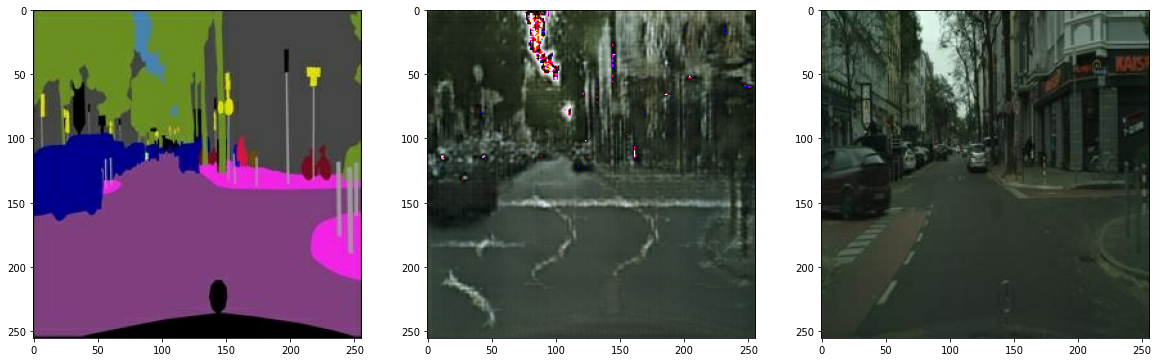

In [50]:
test_ind = 1
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/test/'
f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

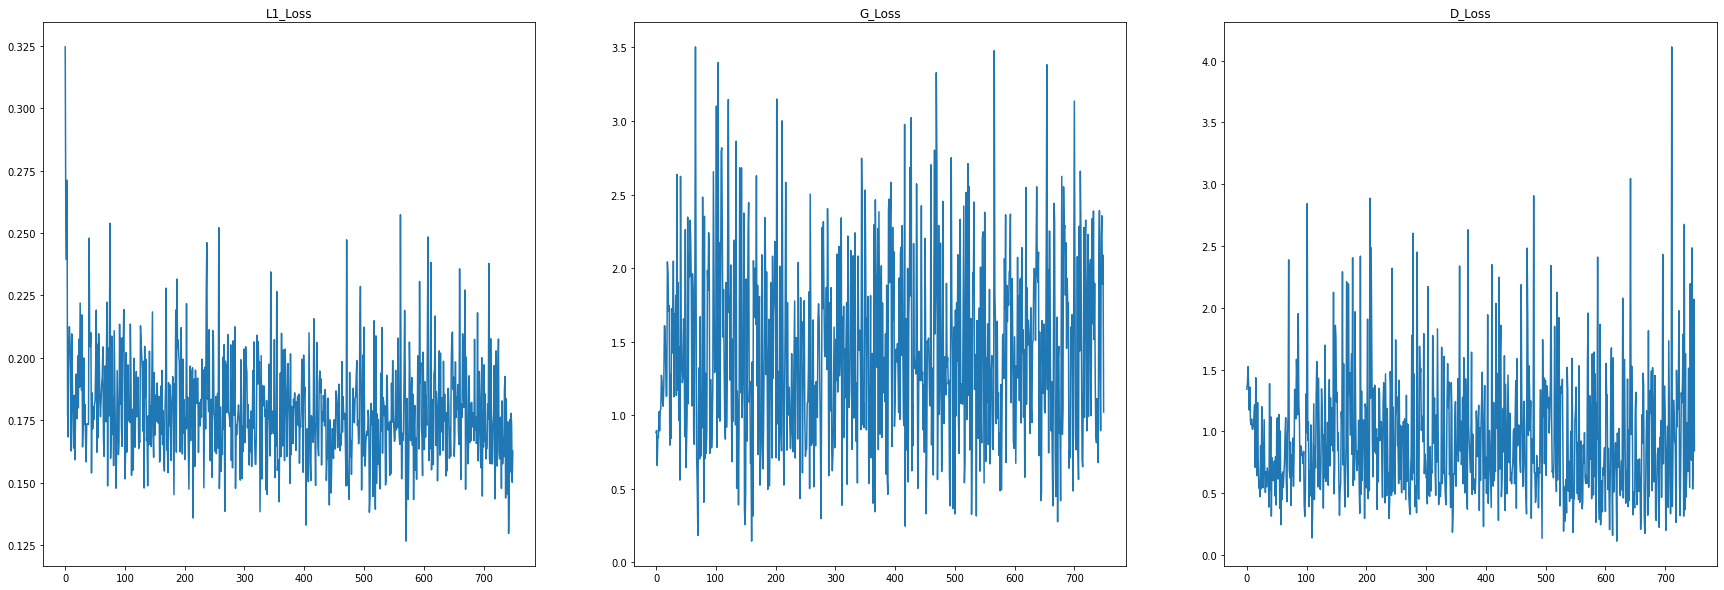

In [56]:
step=[i for i in range(len(L1loss))]

#L1loss
#3G_loss
#D_loss
fig=plt.figure(figsize=(30,10))
ax1=fig.add_subplot(1, 3, 1)
ax1.set_title("L1_Loss")
ax1.plot(step,L1loss)

ax1=fig.add_subplot(1, 3, 2)S
ax1.set_title("G_Loss")
ax1.plot(step,G_loss)

ax1=fig.add_subplot(1, 3, 3)
ax1.set_title("D_Loss")
ax1.plot(step,D_loss)


range(0, 10)
